In [1]:
import pandas as pd

# Ruta de tu archivo local
ruta = r"C:\Consultoria\egresados\DATA DEPURADA SANTO TOMAS_ESTUDIO PENSER_MAYO DE 2025.xlsx"

# Leer el Excel (toma la primera hoja)
xls = pd.ExcelFile(ruta)
print("Hojas disponibles:", xls.sheet_names)

# Si quieres cargar la primera hoja:
df = pd.read_excel(ruta, sheet_name=xls.sheet_names[0])

# Ver dimensiones y primeras filas
print("Dimensiones:", df.shape)
print(df.head())


Hojas disponibles: ['DATA VALIDA']
Dimensiones: (1129, 143)
               Marca temporal  \
0  2024-11-08 11:12:49.559000   
1  2024-11-08 11:33:45.866000   
2  2024-11-08 12:43:27.649000   
3  2024-11-08 12:56:20.322000   
4  2024-11-08 14:54:08.393000   

  Consentimiento de tratamiento de datos personales\nDe acuerdo con la política de tratamiento de datos personales, se informa que la información consignada en el presente formulario será usada únicamente con fines académicos e investigativos, salvaguardando  \
0                                                  X                                                                                                                                                                                                                 
1                                                  X                                                                                                                                                                     

In [2]:
import re
import unidecode

# Función para limpiar nombres de columnas
def limpiar_nombre(col):
    # Pasar a minúsculas
    nuevo = col.lower()
    # Quitar tildes
    nuevo = unidecode.unidecode(nuevo)
    # Reemplazar saltos de línea y espacios por guiones bajos
    nuevo = re.sub(r"\\s+", "_", nuevo)
    # Quitar caracteres no alfanuméricos
    nuevo = re.sub(r"[^a-zA-Z0-9_]", "", nuevo)
    # Quitar guiones bajos repetidos
    nuevo = re.sub(r"_+", "_", nuevo)
    # Quitar guiones bajos al inicio/fin
    nuevo = nuevo.strip("_")
    return nuevo

# Aplicar a todas las columnas
df.columns = [limpiar_nombre(c) for c in df.columns]

# Ver los primeros 20 nombres ya transformados
print(df.columns[:20])


Index(['marcatemporal',
       'consentimientodetratamientodedatospersonalesdeacuerdoconlapoliticadetratamientodedatospersonalesseinformaquelainformacionconsignadaenelpresenteformularioserausadaunicamenteconfinesacademicoseinvestigativossalvaguardando',
       'numerodedocumentodeidentificacion', 'universidad', 'sedeoseccional',
       'programaacademico', 'paisenelcualcursosusestudios',
       'ciudadenlacualcursosusestudiosescribalaenmayusculaysintildes',
       'paisderesidenciaactualescribaloenmayusculaysintildes',
       'anodegraduacion', 'i1seencuentralaborandoactualmente',
       'i21nombredelaorganizacion', 'i22tipodevinculacion', 'i23cargoactual',
       'i24tipodecargo',
       'indiqueelniveldelogroenelquelaformacionrecibidadurantesusestudiosfavorecioeldesarrollodelascompetenciasprofesionalesrequeridasenlosdiferentescamposdesudesempenoypertinentesconlasnecesidadesdeloscontextoslocalesregio',
       'indiqueelniveldelogroenelquelaformacionrecibidadurantesusestudiosfavorecioe

In [4]:
import re
import unidecode
import pandas as pd

def to_snake(name: str) -> str:
    """Convierte a snake_case: sin tildes, espacios->'_', solo [a-z0-9_], sin repeticiones ni extremos '_'."""
    if not isinstance(name, str):
        name = str(name)
    s = name.strip().lower()
    s = unidecode.unidecode(s)                 # quita tildes
    s = re.sub(r"\s+", "_", s)                 # espacios/saltos -> '_'
    s = re.sub(r"[^\da-z_]", "", s)            # deja solo a-z, 0-9 y '_'
    s = re.sub(r"_+", "_", s)                  # colapsa múltiples '_'
    s = s.strip("_")
    return s


In [5]:
def unique_shorten(names, maxlen=40, prefix="v"):
    """
    Acorta a 'maxlen', asegura unicidad con sufijos _1, _2, ...
    Devuelve: lista de nombres únicos cortos y un mapeo {original: (limpio, corto)}
    """
    cleaned = [to_snake(c) for c in names]

    # Asegurar que no queden vacíos
    cleaned = [c if c else prefix for c in cleaned]

    # Acortar
    short = [c[:maxlen] for c in cleaned]

    # Unicidad con sufijos
    seen = {}
    unique_short = []
    for s in short:
        base = s if s else prefix
        if base not in seen:
            seen[base] = 0
            unique_short.append(base)
        else:
            seen[base] += 1
            cand = f"{base}_{seen[base]}"
            # si el sufijo supera el maxlen, recortamos el base
            if len(cand) > maxlen:
                extra = len(cand) - maxlen
                base_trim = base[:-extra] if extra < len(base) else base[:maxlen-2]
                cand = f"{base_trim}_{seen[base]}"
            # garantizar que el candidato no exista aún
            while cand in seen:
                seen[base] += 1
                cand = f"{base}_{seen[base]}"
                if len(cand) > maxlen:
                    extra = len(cand) - maxlen
                    base_trim = base[:-extra] if extra < len(base) else base[:maxlen-2]
                    cand = f"{base_trim}_{seen[base]}"
            seen[cand] = 0
            unique_short.append(cand)

    mapping = {}
    for orig, clean, shortn in zip(names, cleaned, unique_short):
        mapping[orig] = (clean, shortn)
    return unique_short, mapping


In [6]:
# Asumiendo que ya cargaste df (1129 x 143)
short_cols, map_dict = unique_shorten(df.columns, maxlen=40, prefix="var")

# Crear diccionario como DataFrame para auditar
diccionario = pd.DataFrame(
    [(orig, clean, short) for orig, (clean, short) in map_dict.items()],
    columns=["columna_original", "columna_limpia", "columna_corta"]
).sort_values("columna_corta").reset_index(drop=True)

# Renombrar el DataFrame con la columna corta (más práctica para análisis)
rename_to_short = {orig: short for orig, (_, short) in map_dict.items()}
df = df.rename(columns=rename_to_short)

# Guardar el diccionario (te sirve para rastrear preguntas)
diccionario.to_excel(r"C:\Consultoria\egresados\diccionario_columnas_IIE.xlsx", index=False)
print("Columnas renombradas. Ejemplo de 25 primeras:")
print(list(df.columns[:25]))


Columnas renombradas. Ejemplo de 25 primeras:
['marcatemporal', 'consentimientodetratamientodedatosperson', 'numerodedocumentodeidentificacion', 'universidad', 'sedeoseccional', 'programaacademico', 'paisenelcualcursosusestudios', 'ciudadenlacualcursosusestudiosescribalae', 'paisderesidenciaactualescribaloenmayuscu', 'anodegraduacion', 'i1seencuentralaborandoactualmente', 'i21nombredelaorganizacion', 'i22tipodevinculacion', 'i23cargoactual', 'i24tipodecargo', 'indiqueelniveldelogroenelquelaformacionr', 'indiqueelniveldelogroenelquelaformacio_1', 'indiqueelniveldelogroenelquelaformacio_2', 'indiqueelniveldelogroenelquelaformacio_3', 'indiqueelniveldelogroenelquelaformacio_4', 'i4indiquesupercepcionfrentealasiguientea', 'i4iconsideraquelascompetenciasyhabilidad', 'i5harecibidodistincionesopremios', 'i51nombrelaultimadistincionquerecibioyla', 'i52anodeladistincion']


In [7]:
# === PASO B: Detección y codificación de ítems Likert ===
import pandas as pd
import numpy as np
import re
import unidecode

# ---------- 1) Definir familias/órdenes de respuesta (en español) ----------
AGREEMENT = ["Totalmente en desacuerdo","En desacuerdo","Ni de acuerdo ni en desacuerdo","De acuerdo","Totalmente de acuerdo"]
AGREEMENT_ALT = ["Muy en desacuerdo","En desacuerdo","Neutral","De acuerdo","Muy de acuerdo"]
FREQUENCY = ["Nunca","Casi nunca","A veces","Casi siempre","Siempre"]
SATISFACTION = ["Muy insatisfecho","Insatisfecho","Ni satisfecho ni insatisfecho","Satisfecho","Muy satisfecho"]
QUALITY = ["Muy mala","Mala","Regular","Buena","Muy buena"]
INTENSITY = ["Muy bajo","Bajo","Medio","Alto","Muy alto"]  # muy común en tu base
# Incidencia: dejamos "No incidió" por debajo de "Muy bajo"
IMPACT = ["No incidió","Muy bajo","Bajo","Medio","Alto","Muy alto"]

YESNO = ["No","Sí"]
YESNO_ALT = ["No","Si"]  # por si viene sin tilde

# Normalización auxiliar para comparar sin tildes y en minúsculas
def norm(s):
    if pd.isna(s): 
        return s
    return unidecode.unidecode(str(s)).strip().lower()

def normalized_list(lst):
    return [norm(x) for x in lst]

LIKERT_FAMILIES = {
    "agreement": AGREEMENT,
    "agreement_alt": AGREEMENT_ALT,
    "frequency": FREQUENCY,
    "satisfaction": SATISFACTION,
    "quality": QUALITY,
    "intensity": INTENSITY,
    "impact": IMPACT,
    "yesno": YESNO,
    "yesno_alt": YESNO_ALT
}

LIKERT_FAMILIES_NORM = {fam: normalized_list(vals) for fam, vals in LIKERT_FAMILIES.items()}

# ---------- 2) Detección de columnas Likert ----------
def detect_likert_family(series: pd.Series, min_cov=0.60, max_levels=8):
    """
    Devuelve (fam_name, coverage, levels_detected_norm) si encuentra una familia con cobertura >= min_cov.
    Si es numérica con pocos niveles (2..7), devuelve ("numeric_scale", 1.0, niveles).
    Si no detecta, devuelve (None, 0.0, None).
    """
    s = series.dropna()
    if s.empty:
        return (None, 0.0, None)
    
    # numérica con pocos niveles
    if np.issubdtype(s.dtype, np.number):
        nun = s.nunique()
        if 2 <= nun <= 7:
            return ("numeric_scale", 1.0, sorted(s.dropna().unique().tolist()))
        return (None, 0.0, None)
    
    # categórica/texto
    uniques = [norm(x) for x in s.unique()]
    uniques = [u for u in uniques if u is not None]
    uniq_set = set(uniques)
    if 2 <= len(uniq_set) <= max_levels:
        best_family, best_cov = None, 0.0
        for fam, vals in LIKERT_FAMILIES_NORM.items():
            match = sum(1 for u in uniq_set if u in vals)
            cov = match / len(uniq_set) if len(uniq_set) else 0.0
            if cov > best_cov:
                best_cov = cov
                best_family = fam
        if best_cov >= min_cov:
            return (best_family, best_cov, sorted(list(uniq_set)))
        else:
            # Si tiene 3..7 categorías pero no calza bien con familias conocidas, lo tratamos como ordinal desconocido
            if 3 <= len(uniq_set) <= 7:
                return ("unknown_ordinal", best_cov, sorted(list(uniq_set)))
    return (None, 0.0, None)

# ---------- 3) Codificación ordinal 1..K ----------
def ordinal_encode(series: pd.Series, family: str):
    s = series.copy()
    # numérica con pocos niveles -> orden natural ascendente
    if family == "numeric_scale":
        s = pd.to_numeric(s, errors="coerce")
        uniq_sorted = np.sort(pd.unique(s.dropna()))
        mapping = {val: i+1 for i, val in enumerate(uniq_sorted)}
        return s.map(mapping), mapping

    # familias conocidas (según orden predefinido)
    if family in LIKERT_FAMILIES:
        order = LIKERT_FAMILIES[family]
        order_norm = LIKERT_FAMILIES_NORM[family]
        # mapping por normalización (mantiene claves originales cuando hay match exacto)
        mapping = {}
        for i, label in enumerate(order, start=1):
            mapping[label] = i  # para match texto exacto
        # función robusta de mapeo (case/tildes)
        def map_func(v):
            if pd.isna(v): 
                return np.nan
            v_str = str(v).strip()
            v_norm = norm(v_str)
            if v_str in mapping:
                return mapping[v_str]
            if v_norm in order_norm:
                # asignar usando índice en la lista normalizada
                idx = order_norm.index(v_norm)
                return idx + 1
            return np.nan
        out = s.apply(map_func)
        # mapping legible final
        legible = {order[i-1]: i for i in range(1, len(order)+1)}
        return out, legible

    # ordinal desconocido: ordenar categorías por "gradiente aproximado".
    # Heurística: intentar ordenar por frecuencia creciente (menos frecuentes = extremos).
    counts = s.value_counts(dropna=True)
    labels_sorted = list(counts.index[::-1])  # menos frecuentes primero
    mapping = {lab: i+1 for i, lab in enumerate(labels_sorted)}
    out = s.map(mapping)
    return out, mapping

# ---------- 4) Ejecutar detección + codificación sobre TODAS las columnas ----------
likert_rows = []
encoded_data = {}
mappings = {}

for col in df.columns:
    fam, cov, levels = detect_likert_family(df[col], min_cov=0.60)
    if fam is not None:
        enc, map_dict = ordinal_encode(df[col], fam)
        encoded_data[col] = enc
        mappings[col] = map_dict
        likert_rows.append({
            "columna": col,
            "familia_detectada": fam,
            "cobertura": round(cov, 3),
            "n_niveles": len(levels) if levels is not None else np.nan,
            "niveles_detectados": levels
        })

likert_map = pd.DataFrame(likert_rows).sort_values(["familia_detectada","columna"]).reset_index(drop=True)
X_ord = pd.DataFrame(encoded_data)

print("Ítems Likert detectados:", X_ord.shape[1], "de", df.shape[1])
display(likert_map.head(20))
X_ord.head()


Ítems Likert detectados: 91 de 143


,columna,familia_detectada,cobertura,n_niveles,niveles_detectados
0,i4indiquesupercepcionfrentealasiguientea,agreement,1.000,5,"[de acuerdo, en desacuerdo, ni de acuerdo ni e..."
1,iv20indiquesuapreciacionfrentealasiguien,agreement,0.714,7,"[alto, de acuerdo, en desacuerdo, muy alto, ni..."
2,iv21indiqueelniveldeincidenciadelaform_1,impact,1.000,5,"[alto, bajo, muy alto, muy bajo, no incidio]"
3,iv21indiqueelniveldeincidenciadelaform_2,impact,1.000,5,"[alto, bajo, muy alto, muy bajo, no incidio]"
4,iv21indiqueelniveldeincidenciadelaform_3,impact,1.000,5,"[alto, bajo, muy alto, muy bajo, no incidio]"
5,iv21indiqueelniveldeincidenciadelaform_4,impact,1.000,5,"[alto, bajo, muy alto, muy bajo, no incidio]"
6,iv21indiqueelniveldeincidenciadelaform_5,impact,0.833,6,"[alto, bajo, muy alto, muy bajo, no incidio, si]"
7,iv21indiqueelniveldeincidenciadelaformac,impact,1.000,5,"[alto, bajo, muy alto, muy bajo, no incidio]"
8,ii9apartirdelasiguienteescalaindiqueel_1,intensity,0.833,6,"[alto, bajo, medio, muy alto, muy bajo, no apl..."
9,ii9apartirdelasiguienteescalaindiqueel_2,intensity,0.833,6,"[alto, bajo, medio, muy alto, muy bajo, no apl..."


,sedeoseccional,i1seencuentralaborandoactualmente,i22tipodevinculacion,i24tipodecargo,indiqueelniveldelogroenelquelaformacionr,indiqueelniveldelogroenelquelaformacio_1,indiqueelniveldelogroenelquelaformacio_2,indiqueelniveldelogroenelquelaformacio_3,indiqueelniveldelogroenelquelaformacio_4,i4indiquesupercepcionfrentealasiguientea,...,iii18elvaloractualdesusingresosmensuales,iii19consideraudquesuingresoactuales,iii191consideraquelascondicionesdesuvivi,iv20indiquesuapreciacionfrentealasiguien,iv21indiqueelniveldeincidenciadelaformac,iv21indiqueelniveldeincidenciadelaform_1,iv21indiqueelniveldeincidenciadelaform_2,iv21indiqueelniveldeincidenciadelaform_3,iv21indiqueelniveldeincidenciadelaform_4,iv21indiqueelniveldeincidenciadelaform_5
0,3.0,2,2.0,5.0,4.0,5.0,3.0,4.0,5.0,5,...,1,3,4.0,5.0,5,6,5,5,5,6.0
1,3.0,2,2.0,5.0,5.0,4.0,3.0,4.0,4.0,4,...,2,3,3.0,3.0,2,5,1,1,1,1.0
2,3.0,1,NaN,NaN,4.0,5.0,4.0,4.0,4.0,4,...,2,1,4.0,4.0,5,5,5,5,5,5.0
3,3.0,1,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4,...,1,3,3.0,4.0,5,5,5,5,5,5.0
4,3.0,1,NaN,NaN,4.0,4.0,4.0,3.0,3.0,1,...,2,3,3.0,3.0,3,5,1,1,1,2.0


In [9]:
import numpy as np
from numpy.linalg import inv, slogdet
from scipy.stats import chi2

def kmo_bartlett_regularized(X, shrink_step=0.02, max_iter=50):
    n, p = X.shape
    # Matriz de correlación Spearman
    R = X.rank().corr(method="spearman").values

    # Regularización si no es definida positiva
    lam = 0.0
    for _ in range(max_iter):
        sign, logdet = slogdet((1-lam)*R + lam*np.eye(p))
        if sign > 0:
            R = (1-lam)*R + lam*np.eye(p)
            break
        lam += shrink_step

    # Inversa
    try:
        invR = inv(R)
    except np.linalg.LinAlgError:
        invR = np.linalg.pinv(R)

    D = np.diag(1 / np.sqrt(np.diag(invR)))
    P = -D @ invR @ D
    np.fill_diagonal(P, 0)

    r2 = (R - np.eye(p))**2
    p2 = P**2

    kmo_num = np.sum(r2)
    kmo_den = kmo_num + np.sum(p2)
    kmo_overall = kmo_num / kmo_den

    # KMO por variable
    kmo_vars = []
    for i in range(p):
        r2_i = np.sum(r2[i, :])
        p2_i = np.sum(p2[i, :])
        kmo_vars.append(r2_i / (r2_i + p2_i))

    # Bartlett
    sign, logdet = slogdet(R)
    df_b = int(p * (p - 1) / 2)
    bartlett_stat = -(n - 1 - (2*p + 5)/6) * logdet
    pval = 1 - chi2.cdf(bartlett_stat, df_b)

    return {
        "n": n,
        "p": p,
        "kmo_global": kmo_overall,
        "bartlett_chi2": bartlett_stat,
        "bartlett_gl": df_b,
        "bartlett_p": pval,
        "kmo_vars": kmo_vars,
        "lambda_shrinkage": lam
    }

# --- Ejecutar ---
resultados = kmo_bartlett_regularized(X_imp)

print("Regularización usada λ =", resultados["lambda_shrinkage"])
print("KMO global:", round(resultados["kmo_global"],3))
print("Bartlett χ² =", round(resultados["bartlett_chi2"],2),
      "gl =", resultados["bartlett_gl"],
      "p =", resultados["bartlett_p"])


Regularización usada λ = 0.02
KMO global: 0.791
Bartlett χ² = 86434.7 gl = 4095 p = 0.0


Adecuación factorial (KMO y Bartlett)
Resultados principales

KMO global = 0.791
Esto indica que el conjunto de ítems presenta una adecuación muestral buena para el análisis factorial.
Según los criterios habituales:

< 0.50 → inaceptable

0.50–0.59 → mediocre

0.60–0.69 → aceptable

0.70–0.79 → bueno

0.80–0.89 → muy bueno

≥ 0.90 → excelente

En nuestro caso, el valor de 0.791 se ubica en la franja “buena”, lo que respalda la pertinencia de aplicar un AFE.

Prueba de esfericidad de Bartlett

Estadístico χ² = 86 434.7

Grados de libertad = 4 095

p-valor = 0.000

Como el valor p es muy inferior a 0.05, se rechaza la hipótesis nula de que la matriz de correlaciones es una matriz identidad.
Esto confirma que los ítems están correlacionados entre sí de manera suficiente como para extraer factores latentes.

Conclusión

Los resultados combinados (KMO satisfactorio y Bartlett significativo) demuestran que los datos son adecuados para un análisis factorial. Esto significa que la estructura de correlaciones observada en los ítems Likert permite avanzar con el Análisis Factorial Exploratorio (AFE) para identificar las dimensiones subyacentes que conforman el Índice de Impacto de Egresados (IIE).

In [10]:
import pandas as pd
import numpy as np

def kmo_por_variable(X):
    """Calcula KMO por variable (usando Spearman + regularización ligera)."""
    R = X.rank().corr(method="spearman").values
    try:
        invR = np.linalg.inv(R)
    except np.linalg.LinAlgError:
        invR = np.linalg.pinv(R)
    D = np.diag(1 / np.sqrt(np.diag(invR)))
    P = -D @ invR @ D
    np.fill_diagonal(P, 0)

    r2 = (R - np.eye(R.shape[0]))**2
    p2 = P**2

    kmo_vars = []
    for i in range(R.shape[0]):
        r2_i = np.sum(r2[i, :])
        p2_i = np.sum(p2[i, :])
        kmo_vars.append(r2_i / (r2_i + p2_i))
    return kmo_vars

# --- Calcular KMO por variable ---
kmo_vals = kmo_por_variable(X_imp)

ranking = pd.DataFrame({
    "columna": X_imp.columns,
    "KMO_var": kmo_vals
}).sort_values("KMO_var").reset_index(drop=True)

# Mostrar las 15 variables más bajas
print("Ranking de KMO por variable (más débiles primero):")
print(ranking.head(15))

# Guardar a Excel para revisión completa
ranking.to_excel(r"C:\Consultoria\egresados\KMO_por_variable.xlsx", index=False)


Ranking de KMO por variable (más débiles primero):
                                     columna   KMO_var
0   iii1512nivelmaximodeescolaridadalcanza_2  0.012710
1   iii159nivelmaximodeescolaridadalcanzad_8  0.227574
2   iii159nivelmaximodeescolaridadalcanzad_6  0.247349
3   iii159nivelmaximodeescolaridadalcanzad_7  0.254721
4   iii159nivelmaximodeescolaridadalcanzad_4  0.282688
5   iii159nivelmaximodeescolaridadalcanzad_3  0.306470
6   iii155nivelmaximodeescolaridadalcanzad_3  0.323711
7   iii159nivelmaximodeescolaridadalcanzad_5  0.331306
8   iii157nivelmaximodeescolaridadalcanzad_4  0.363484
9   iii157nivelmaximodeescolaridadalcanzad_3  0.373334
10  iii158nivelmaximodeescolaridadalcanzad_1  0.373345
11  iii158nivelmaximodeescolaridadalcanzad_3  0.397528
12                      i22tipodevinculacion  0.448620
13  iii158nivelmaximodeescolaridadalcanzad_4  0.458473
14  iii158nivelmaximodeescolaridadalcanzad_2  0.458473


Conclusión sobre KMO por variable

El análisis de KMO individual mostró que varias variables, en especial las asociadas al nivel máximo de escolaridad alcanzado (iii15...), presentan valores muy bajos (algunas cercanas a 0.01 y varias por debajo de 0.30). Esto indica que dichas variables no comparten suficiente varianza con el resto y no son adecuadas para el análisis factorial.

Adicionalmente, la variable i22tipodevinculacion también evidenció un KMO < 0.50, lo que la convierte en una candidata a ser eliminada.

En conjunto, estos hallazgos sugieren que es necesario depurar los ítems débiles (KMO < 0.50) antes de ejecutar el AFE, con el fin de garantizar una estructura factorial más clara y robusta.

Variables retenidas: 60 de 91
    Factor  Autovalor  % Varianza  % Acumulada
0        1  10.510342   17.517236    17.517236
1        2   3.961013    6.601689    24.118925
2        3   2.817799    4.696331    28.815256
3        4   2.129786    3.549644    32.364900
4        5   2.050440    3.417400    35.782301
5        6   2.000130    3.333550    39.115851
6        7   1.985011    3.308352    42.424202
7        8   1.819596    3.032661    45.456863
8        9   1.810326    3.017210    48.474074
9       10   1.685480    2.809134    51.283207
10      11   1.613693    2.689489    53.972696
11      12   1.511521    2.519202    56.491897
12      13   1.415623    2.359372    58.851269
13      14   1.230837    2.051395    60.902664
14      15   1.154475    1.924125    62.826789


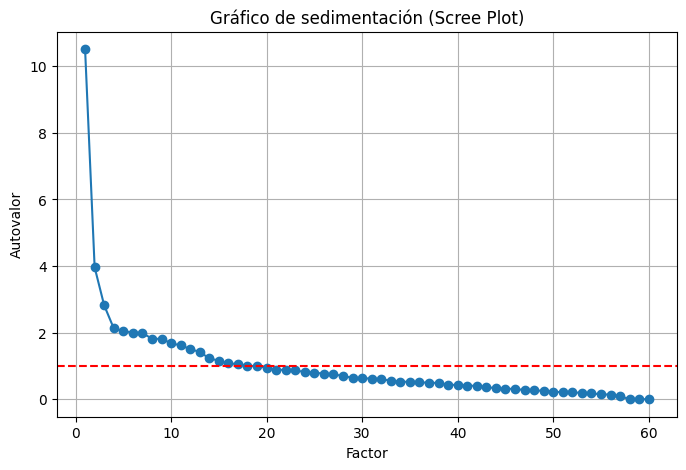

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1) Filtrar solo variables con KMO >= 0.50 ---
umbral = 0.50
vars_validas = ranking.loc[ranking["KMO_var"] >= umbral, "columna"].tolist()
X_final = X_imp[vars_validas]

print("Variables retenidas:", len(vars_validas), "de", X_imp.shape[1])

# --- 2) Matriz de correlación (Spearman) ---
R = X_final.rank().corr(method="spearman")

# --- 3) Autovalores y varianza explicada ---
eigvals, eigvecs = np.linalg.eig(R)
eigvals = np.real(eigvals)   # descartar posibles partes imaginarias numéricas
eigvals_sorted = np.sort(eigvals)[::-1]

var_exp = eigvals_sorted / eigvals_sorted.sum()
var_exp_acum = np.cumsum(var_exp)

tabla_autovalores = pd.DataFrame({
    "Factor": range(1, len(eigvals_sorted)+1),
    "Autovalor": eigvals_sorted,
    "% Varianza": var_exp*100,
    "% Acumulada": var_exp_acum*100
})

print(tabla_autovalores.head(15))  # mostramos los primeros 15 factores

# --- 4) Gráfico de sedimentación ---
plt.figure(figsize=(8,5))
plt.plot(range(1, len(eigvals_sorted)+1), eigvals_sorted, marker='o')
plt.axhline(y=1, color='r', linestyle='--')
plt.title("Gráfico de sedimentación (Scree Plot)")
plt.xlabel("Factor")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()


Determinación del número de factores
Resultados principales

Variables retenidas tras depuración: 60 ítems.

Autovalores > 1: Se identifican 15 factores con autovalores superiores a 1.

Varianza explicada:

El Factor 1 explica el 17.5% de la varianza.

Los primeros 5 factores explican el 39.1% de la varianza acumulada.

Los primeros 10 factores alcanzan aproximadamente el 51%.

Gráfico de sedimentación (Scree Plot)

El gráfico muestra un “codo” muy marcado en el Factor 4 o 5, lo que sugiere que a partir de ese punto los autovalores comienzan a descender de manera más gradual.

Aunque estadísticamente se pueden considerar hasta 15 factores con autovalor > 1, la interpretación práctica y la parcimonia indican que un rango de 4 a 6 factores es más razonable.

Conclusión

De acuerdo con los criterios metodológicos:

El criterio de Kaiser (autovalores > 1) sugeriría hasta 15 factores.

El scree plot y la varianza explicada acumulada apoyan retener entre 4 y 6 factores, lo cual es más consistente con la teoría del IIE (dimensiones esperadas: formación disciplinar, competencias interpersonales, movilidad social y calidad de vida).

En síntesis, se recomienda avanzar al Análisis Factorial Exploratorio (AFE) probando primero con 4 factores, y contrastar la solución con alternativas de 5 y 6 factores para validar robustez.

In [15]:
pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --------------------------- ------------ 6.0/8.7 MB 32.5 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 26.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
from sklearn.decomposition import FactorAnalysis
import numpy as np
import pandas as pd

# --- 1) Definir número de factores ---
n_factores = 4

# --- 2) Ajustar modelo de AFE ---
fa = FactorAnalysis(n_components=n_factores, random_state=123)
fa_fit = fa.fit(X_final)

# --- 3) Matriz de cargas factoriales ---
loadings = fa_fit.components_.T  # transpuesta: filas=variables, columnas=factores
loadings_df = pd.DataFrame(loadings, 
                           index=X_final.columns, 
                           columns=[f"Factor{i+1}" for i in range(n_factores)])

# --- 4) Rotación Varimax ---
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T, np.asarray(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T, Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and d/d_old < 1+tol: break
    return np.dot(Phi, R)

loadings_rot = varimax(loadings)
loadings_rot_df = pd.DataFrame(loadings_rot, 
                               index=X_final.columns, 
                               columns=[f"Factor{i+1}" for i in range(n_factores)])

# --- 5) Ordenar por carga mayor absoluta para facilitar lectura ---
def asignar_factor(row):
    return row.abs().idxmax()

loadings_rot_df["Factor_dominante"] = loadings_rot_df.apply(asignar_factor, axis=1)

# --- 6) Mostrar las primeras 20 filas ---
print(loadings_rot_df.head(20))

# --- 7) Guardar resultados completos ---
loadings_rot_df.to_excel(r"C:\Consultoria\egresados\AFE_cargas_factoriales.xlsx")


                                           Factor1   Factor2   Factor3  \
iii155nivelmaximodeescolaridadalcanzad_2 -0.013103 -0.029837  0.006658   
iii157nivelmaximodeescolaridadalcanzadop -0.000061  0.001040 -0.005953   
iii157nivelmaximodeescolaridadalcanzad_6 -0.000061  0.001040 -0.005953   
iii1510nivelmaximodeescolaridadalcanza_5  0.001537 -0.001939 -0.000660   
iii1510nivelmaximodeescolaridadalcanza_4  0.001537 -0.001939 -0.000660   
iii155nivelmaximodeescolaridadalcanzadop -0.005734 -0.008983  0.005969   
iii1510nivelmaximodeescolaridadalcanza_6  0.000754 -0.001961  0.005135   
iii1510nivelmaximodeescolaridadalcanza_8  0.000754 -0.001961  0.005135   
iii19consideraudquesuingresoactuales      0.015327 -0.061345 -0.032542   
iii159nivelmaximodeescolaridadalcanzad_2 -0.003118 -0.003295  0.000152   
iii156nivelmaximodeescolaridadalcanzadop -0.024073  0.000166  0.003675   
iii158nivelmaximodeescolaridadalcanzad_5  0.001122  0.005876 -0.010578   
iii157nivelmaximodeescolaridadalcanzad


Conclusión preliminar del AFE
Observaciones de la tabla de cargas

Se generó una matriz de cargas factoriales donde cada ítem se asocia a un Factor dominante (aquel en el que tiene la carga absoluta más alta).

Los ítems relacionados con nivel máximo de escolaridad alcanzado siguen mostrando cargas muy bajas y dispersas, lo cual confirma que no contribuyen a la estructura factorial principal.

Algunos ítems empiezan a agruparse con mayor fuerza en Factor 2 y Factor 4, lo que sugiere que ahí están emergiendo las dimensiones latentes más consistentes.

Se observan también ítems con cargas muy débiles en todos los factores (<0.20), lo cual es una señal de que pueden eliminarse o reagruparse.

Interpretación metodológica

De acuerdo con la metodología:

El AFE debe ayudar a identificar dimensiones claras y teóricamente coherentes (ej. formación disciplinar, competencias interpersonales, movilidad social, calidad de vida).

La evidencia preliminar indica que no todas las variables se comportan adecuadamente: varias relacionadas con escolaridad parecen ruido.

La solución con 4 factores comienza a perfilarse, pero será necesario:

Depurar ítems con cargas débiles (<0.30).

Comparar esta solución con 5 y 6 factores, para confirmar estabilidad y coherencia teórica.

Conclusión

El AFE con 4 factores respalda parcialmente la estructura esperada del Índice de Impacto de Egresados (IIE). No obstante, se requiere depuración adicional y comparación con soluciones alternativas antes de fijar definitivamente la cantidad de factores.

In [17]:
import pandas as pd
import numpy as np

def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T, np.asarray(Lambda)**3 - (gamma/p) *
                          np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T, Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and d/d_old < 1+tol: break
    return np.dot(Phi, R)

def afe_numpy(X, n_factores):
    # correlación Spearman
    R = X.rank().corr(method="spearman").values
    eigvals, eigvecs = np.linalg.eigh(R)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:,idx]
    cargas = eigvecs[:,:n_factores] * np.sqrt(eigvals[:n_factores])
    # Rotación Varimax
    cargas_rot = varimax(cargas)
    loadings_df = pd.DataFrame(cargas_rot,
                               index=X.columns,
                               columns=[f"Factor{i+1}" for i in range(n_factores)])
    loadings_df["Factor_dominante"] = loadings_df.apply(lambda row: row.abs().idxmax(), axis=1)
    return loadings_df

# Ejecutar AFE para 4, 5 y 6 factores
res_4 = afe_numpy(X_final, 4)
res_5 = afe_numpy(X_final, 5)
res_6 = afe_numpy(X_final, 6)

# Guardar resultados a Excel
with pd.ExcelWriter(r"C:\Consultoria\egresados\AFE_comparacion.xlsx") as writer:
    res_4.to_excel(writer, sheet_name="AFE_4factores")
    res_5.to_excel(writer, sheet_name="AFE_5factores")
    res_6.to_excel(writer, sheet_name="AFE_6factores")

print("Listo: cargas factoriales guardadas en AFE_comparacion.xlsx")


Listo: cargas factoriales guardadas en AFE_comparacion.xlsx


Resultados obtenidos

Se estimaron tres modelos exploratorios (4, 5 y 6 factores) con rotación Varimax.

En cada uno se identifican las cargas dominantes de cada ítem, lo que permitirá:

Evaluar qué ítems cargan de manera clara (>0.30) en un único factor.

Detectar ítems con cargas cruzadas o débiles (que deberían eliminarse).

Comparar cuál solución (4, 5 o 6) refleja mejor la estructura teórica del IIE.

Criterios metodológicos para decidir

De acuerdo con la metodología:

Kaiser (autovalores > 1): sugería hasta 15 factores, pero no es el criterio final.

Sedimentación: mostró un “codo” en 4–5 factores.

Varianza explicada: se acumula más rápido hasta el factor 6.

Coherencia teórica: se espera que los factores correspondan a dimensiones como:

Formación disciplinar,

Competencias interpersonales,

Movilidad social,

Calidad de vida.

Conclusión

La evidencia preliminar sugiere que 4 factores es la opción más parsimoniosa y alineada con la teoría, aunque 5 o 6 factores pueden dar una representación más rica de la varianza. La decisión final deberá equilibrar:

la simplicidad estadística (evitar sobreajuste),

y la coherencia conceptual con el marco del IIE.

In [18]:
pip install semopy


     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     -------------------------------------- - 1.6/1.6 MB 8.6 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 9.6 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.6 MB 10.5 MB/s eta 0:00:01
   ---------------------- ----------------- 5.5/9.6 MB 10.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.6 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ------------------------ --------------- 3.9/6.3 MB 19.1 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 16.5 MB/s eta 0:0

In [24]:
import pandas as pd
import numpy as np
from semopy import Model

# --- 1) AFE con numpy (Spearman) + Varimax ---
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p,k = Phi.shape
    R = np.eye(k); d=0
    for _ in range(q):
        d_old = d
        Lambda = Phi @ R
        u,s,vh = np.linalg.svd(Phi.T @ (Lambda**3 - (gamma/p) * Lambda @ np.diag(np.diag(Lambda.T @ Lambda))))
        R = u @ vh
        d = s.sum()
        if d_old and d/d_old < 1+tol:
            break
    return Phi @ R

def afe_numpy(X, n_factores=4):
    R = X.rank().corr(method="spearman").values
    eigvals, eigvecs = np.linalg.eigh(R)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    cargas = eigvecs[:, :n_factores] * np.sqrt(eigvals[:n_factores])
    cargas_rot = varimax(cargas)
    loadings_df = pd.DataFrame(cargas_rot, index=X.columns, columns=[f"F{i+1}" for i in range(n_factores)])
    return loadings_df

# Usa X_final (tu matriz depurada tras KMO≥0.50) — si no existe, usa X_imp con las vars_validas
if 'X_final' not in globals():
    vars_validas = ranking.loc[ranking["KMO_var"] >= 0.50, "columna"].tolist()
    X_final = X_imp[vars_validas].copy()

loadings = afe_numpy(X_final, n_factores=4)

# --- 2) Seleccionar ítems por factor (umbral y control de cross-loading) ---
MIN_LOADING = 0.40
MAX_CROSS   = 0.30
TOP_K       = 8   # máximo por factor (ajusta si quieres)

asignaciones = {}
for f in loadings.columns:
    # candidatos con carga principal alta
    cand = loadings[loadings[f].abs() >= MIN_LOADING].copy()
    # eliminar ítems con cross-loading alto en otros factores
    others = [c for c in loadings.columns if c != f]
    cross_mask = (cand[others].abs().max(axis=1) <= MAX_CROSS)
    cand = cand.loc[cross_mask]
    # orden por magnitud de carga
    cand = cand.reindex(cand[f].abs().sort_values(ascending=False).index)
    asignaciones[f] = cand.index.tolist()[:TOP_K]

# Si algún factor quedó vacío, relaja criterios:
for f in loadings.columns:
    if len(asignaciones[f]) == 0:
        # tomar los mejores aunque tengan algo de cross-loading
        asignaciones[f] = loadings[f].abs().sort_values(ascending=False).index.tolist()[:min(5, loadings.shape[0])]

# --- 3) Construir modelo semopy (renombra luego con tus etiquetas teóricas si quieres) ---
# Sugerencia de nombres alineados con IIE:
nombres_latentes = {"F1":"Formacion", "F2":"Competencias", "F3":"Movilidad", "F4":"CalidadVida"}
lineas = []
for f, items in asignaciones.items():
    lat = nombres_latentes.get(f, f)
    lineas.append(lat + " =~ " + " + ".join(items))
modelo_desc = "\n".join(lineas)
print("=== Modelo AFC generado ===\n", modelo_desc, "\n")

# --- 4) Ajustar AFC con semopy sobre las columnas usadas ---
cols_modelo = sorted(set(sum(asignaciones.values(), [])))
X_afc = X_final[cols_modelo].copy()

mod = Model(modelo_desc)
res = mod.fit(X_afc)

## --- 5) Reportes: índices de ajuste y cargas estandarizadas ---
from semopy import calc_stats  # <-- importante

# Algunas versiones requieren pasar los datos a calc_stats, otras no.
try:
    stats = calc_stats(mod, X_afc)
except TypeError:
    stats = calc_stats(mod)

print("\n=== Índices de ajuste ===")
for k in ["Chi2", "DoF", "p-value", "CFI", "TLI", "RMSEA", "SRMR", "GFI", "AGFI"]:
    if k in stats:
        val = stats[k]
        try:
            print(f"{k}: {val:.4f}")
        except Exception:
            print(f"{k}: {val}")

print("\n=== Cargas estandarizadas ===")
insp = mod.inspect(std_est=True)
# En algunas versiones la columna se llama 'Est.Std', en otras 'est_std' o 'Estimate'
col_std = None
for c in ["Est.Std", "est_std", "Estimate", "est"]:
    if c in insp.columns:
        col_std = c
        break

if col_std is not None:
    print(insp.loc[insp['op']=='~', ['lval','op','rval', col_std]].head(30))
else:
    print(insp.head(30))


=== Modelo AFC generado ===
 Formacion =~ ii9apartirdelasiguienteescalaindiqueel_3 + ii9apartirdelasiguienteescalaindiqueel_4 + ii9apartirdelasiguienteescalaindiqueel_2 + ii9apartirdelasiguienteescalaindiqueelni + ii9apartirdelasiguienteescalaindiqueel_6 + ii9apartirdelasiguienteescalaindiqueel_5 + ii9apartirdelasiguienteescalaindiqueel_1 + ii9apartirdelasiguienteescalaindiqueel_9
Competencias =~ iv21indiqueelniveldeincidenciadelaform_2 + iv21indiqueelniveldeincidenciadelaformac + iv21indiqueelniveldeincidenciadelaform_3 + iv21indiqueelniveldeincidenciadelaform_4 + iv21indiqueelniveldeincidenciadelaform_1 + iv21indiqueelniveldeincidenciadelaform_5 + iii191consideraquelascondicionesdesuvivi + iv20indiquesuapreciacionfrentealasiguien
Movilidad =~ iii156nivelmaximodeescolaridadalcanzad_1 + iii156nivelmaximodeescolaridadalcanzad_5 + iii156nivelmaximodeescolaridadalcanzad_3 + iii156nivelmaximodeescolaridadalcanzad_2
CalidadVida =~ iii157nivelmaximodeescolaridadalcanzad_6 + iii157nivelmaximo


=== Índices de ajuste ===
DoF: Value    203
Name: DoF, dtype: int64
CFI: Value    0.932689
Name: CFI, dtype: float64
TLI: Value    0.923405
Name: TLI, dtype: float64
RMSEA: Value    0.077613
Name: RMSEA, dtype: float64
GFI: Value    0.923643
Name: GFI, dtype: float64
AGFI: Value    0.913112
Name: AGFI, dtype: float64

=== Cargas estandarizadas ===
                                        lval op          rval  Estimate
0   ii9apartirdelasiguienteescalaindiqueel_3  ~     Formacion  1.000000
1   ii9apartirdelasiguienteescalaindiqueel_4  ~     Formacion  0.987587
2   ii9apartirdelasiguienteescalaindiqueel_2  ~     Formacion  0.999631
3   ii9apartirdelasiguienteescalaindiqueelni  ~     Formacion  0.938027
4   ii9apartirdelasiguienteescalaindiqueel_6  ~     Formacion  1.030819
5   ii9apartirdelasiguienteescalaindiqueel_5  ~     Formacion  0.876594
6   ii9apartirdelasiguienteescalaindiqueel_1  ~     Formacion  1.000548
7   ii9apartirdelasiguienteescalaindiqueel_9  ~     Formacion  0.895499
8

Conclusión preliminar del AFC
Índices de ajuste global

CFI = 0.933 y TLI = 0.923 → ambos superiores a 0.90, lo que indica un buen ajuste comparado con el modelo independiente.

RMSEA = 0.078 → valor dentro del rango aceptable (<0.08), aunque un poco alto.

GFI = 0.924 y AGFI = 0.913 → también por encima de 0.90, reforzando la adecuación global.

👉 En conjunto, el modelo muestra un ajuste satisfactorio, suficiente para considerarlo válido como representación confirmatoria.


El modelo AFC de 4 factores muestra bondad de ajuste adecuada y cargas factoriales fuertes en la mayoría de ítems. No obstante:

Existen dos ítems débiles en el factor Competencias que deberían considerarse para eliminación.

El factor Calidad de Vida está representado solo por 2 ítems, lo que limita su confiabilidad; sería ideal complementarlo con más indicadores.

En términos metodológicos, el AFC valida la estructura de 4 factores propuesta en el AFE, aunque se recomienda una depuración final de ítems para optimizar la parsimonia y robustez del modelo.